In [ ]:
"""
!pip install torch==1.13.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers==4.30.0
!pip install datasets==2.13.2
!pip install accelerate -U
!pip install evaluate
!pip install ipywidgets
"""

In [64]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
# data and numerical management packages
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# useful during debugging (progress bars)
from tqdm import tqdm
from transformers import set_seed

seed = 852

random.seed(seed)
np.random.seed(seed)
set_seed(seed)

## Dataset Creation

In [65]:
dataset_folder = Path.cwd().joinpath("Datasets")
training_arguments_path = dataset_folder.joinpath('arguments-training.tsv')
validation_arguments_path = dataset_folder.joinpath('arguments-validation.tsv')
test_arguments_path = dataset_folder.joinpath('arguments-test.tsv')
training_labels_path = dataset_folder.joinpath('labels-training.tsv')
validation_labels_path = dataset_folder.joinpath('labels-validation.tsv')
test_labels_path = dataset_folder.joinpath('labels-test.tsv')

# Read datasets into Pandas DataFrames
training_arguments = pd.read_csv(training_arguments_path, sep='\t')
validation_arguments = pd.read_csv(validation_arguments_path, sep='\t')
test_arguments = pd.read_csv(test_arguments_path, sep='\t')

training_labels = pd.read_csv(training_labels_path, sep='\t')
validation_labels = pd.read_csv(validation_labels_path, sep='\t')
test_labels = pd.read_csv(test_labels_path, sep='\t')

In [66]:
training_data = pd.merge(training_arguments, training_labels, on=['Argument ID'])
validation_data = pd.merge(validation_arguments, validation_labels, on=['Argument ID'])
test_data = pd.merge(test_arguments, test_labels, on=['Argument ID'])

In [67]:
def merge_columns(df, columns_to_merge, new_column_name):
    df[new_column_name] = df[columns_to_merge].max(axis=1)


In [68]:
columns_group1 = ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism'] # Openeness to change
columns_group2 = ['Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face'] # Self-enhancement
columns_group3 = ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility'] # Conservation
columns_group4 = ['Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity'] # Self-transcendence

merge_columns(training_data, columns_group1, 'Openeness to change')
merge_columns(validation_data, columns_group1, 'Openeness to change')
merge_columns(test_data, columns_group1, 'Openeness to change')

merge_columns(training_data, columns_group2, 'Self-enhancement')
merge_columns(validation_data, columns_group2, 'Self-enhancement')
merge_columns(test_data, columns_group2, 'Self-enhancement')

merge_columns(training_data, columns_group3, 'Conservation')
merge_columns(validation_data, columns_group3, 'Conservation')
merge_columns(test_data, columns_group3, 'Conservation')

merge_columns(training_data, columns_group4, 'Self-transcendence')
merge_columns(validation_data, columns_group4, 'Self-transcendence')
merge_columns(test_data, columns_group4, 'Self-transcendence')

In [69]:
def drop_merged_columns(df,columns_to_drop):
    df.drop(columns=columns_to_drop, inplace=True)

In [70]:
columns_group2_mod = ['Achievement', 'Power: dominance', 'Power: resources', 'Face']
columns_group3_mod = ['Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility']
columns_group4_mod = ['Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']

drop_merged_columns(training_data,columns_group1)
drop_merged_columns(validation_data,columns_group1)
drop_merged_columns(test_data,columns_group1)

drop_merged_columns(training_data,columns_group2_mod)
drop_merged_columns(validation_data,columns_group2_mod)
drop_merged_columns(test_data,columns_group2_mod)

drop_merged_columns(training_data,columns_group3_mod)
drop_merged_columns(validation_data,columns_group3_mod)
drop_merged_columns(test_data,columns_group3_mod)

drop_merged_columns(training_data,columns_group4_mod)
drop_merged_columns(validation_data,columns_group4_mod)
drop_merged_columns(test_data,columns_group4_mod)

In [71]:
training_data.head()

,Argument ID,Conclusion,Stance,Premise,Openeness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


In [72]:
training_data['Stance'] = training_data['Stance'].apply(lambda x: 0 if x.strip() == 'against' else 1)
validation_data['Stance'] = validation_data['Stance'].apply(lambda x: 0 if x.strip() == 'against' else 1)
test_data['Stance'] = test_data['Stance'].apply(lambda x: 0 if x.strip() == 'against' else 1)

## Uniform and Most Common Classifiers

In [73]:
from sklearn.dummy import DummyClassifier
baseline_RUClf = DummyClassifier(strategy="uniform",random_state=seed)
baseline_MClf = DummyClassifier(strategy="most_frequent",random_state=seed)

def get_values(df):
    higher_order_values = []
    for _, row in df.iterrows():
        values = []
        values.append(row['Openeness to change'])
        values.append(row['Self-enhancement'])
        values.append(row['Conservation'])
        values.append(row['Self-transcendence'])

        higher_order_values.append(np.array(values,dtype=float))
    return higher_order_values

higher_order_values_training = get_values(training_data)
higher_order_values_validation = get_values(validation_data)
higher_order_values_test = get_values(test_data)

In [74]:
from transformers import EvalPrediction
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

recall_precision_cm_list = []

def round_elements(x):
    return 1 if x > 0. else 0

def compute_metrics(prediction_label_pairs, is_dummy = False, save_results = False):

    if is_dummy == False: #HuggingFace
      predictions = prediction_label_pairs.predictions
      predictions = np.vectorize(round_elements)(predictions)
      labels = prediction_label_pairs.label_ids
    else:
      predictions = prediction_label_pairs[0]
      labels = prediction_label_pairs[1]

    f1_scores = []
    metrics_on_value = []

    for i in range(predictions.shape[1]):
        cm = confusion_matrix(labels[:, i], predictions[:, i])
        precision = precision_score(labels[:, i], predictions[:, i])
        recall = recall_score(labels[:, i], predictions[:, i])
        if save_results:
          metrics_on_value.append((recall,precision,cm))
        f1 = f1_score(labels[:, i], predictions[:, i], average='binary',zero_division=0.0)
        f1_scores.append(f1)

    average_f1 = np.mean(f1_scores)

    metrics = {
        'Openness to change F1': f1_scores[0],
        'Self-enhancement F1': f1_scores[1],
        'Conversation F1': f1_scores[2],
        'Self-transcendence F1': f1_scores[3],
        'Average F1': average_f1
    }
    if save_results:
      recall_precision_cm_list.append(metrics_on_value)
    return metrics

In [75]:
def splitted_dummy_classifier(strategy,test_set):
  classifiers = {
      'Openness to change': DummyClassifier(strategy=strategy, random_state=seed),
      'Self-enhancement': DummyClassifier(strategy=strategy, random_state=seed),
      'Conservation': DummyClassifier(strategy=strategy, random_state=seed),
      'Self-transcendence': DummyClassifier(strategy=strategy, random_state=seed)
    }
  higher_order_values_training_numpy = np.array(higher_order_values_training)

  # Train each classifier on its respective category
  i = 0
  for category, clf in classifiers.items():
      clf.fit(None, higher_order_values_training_numpy[:,i])
      i+=1

  predictions = {category: clf.predict(test_set) for category, clf in classifiers.items()}

  # Transform predictions into a 2D array format
  predictions_array = np.array(np.column_stack(list(predictions.values())))
  return predictions_array

In [76]:
prediction_uniform_val = splitted_dummy_classifier("uniform",higher_order_values_validation)
prediction_uniform_test = splitted_dummy_classifier("uniform",higher_order_values_test)
metrics_uniform_val = compute_metrics((prediction_uniform_val, np.array(higher_order_values_validation)),True)
metrics_uniform_test = compute_metrics((prediction_uniform_test, np.array(higher_order_values_test)),True,True)
print(metrics_uniform_val)
print(metrics_uniform_test)

{'Openness to change F1': 0.4165651644336176, 'Self-enhancement F1': 0.4822307271733188, 'Conversation F1': 0.5983122362869199, 'Self-transcendence F1': 0.6171428571428572, 'Average F1': 0.5285627462591784}
{'Openness to change F1': 0.3826086956521739, 'Self-enhancement F1': 0.4575799721835883, 'Conversation F1': 0.5801047120418847, 'Self-transcendence F1': 0.6158329286061194, 'Average F1': 0.5090315771209416}


In [77]:
prediction_most_frequent_val = splitted_dummy_classifier("most_frequent",higher_order_values_validation)
prediction_most_frequent_test = splitted_dummy_classifier("most_frequent",higher_order_values_test)
metrics_most_common_val = compute_metrics((prediction_most_frequent_val, np.array(higher_order_values_validation)),True)
metrics_most_common_test = compute_metrics((prediction_most_frequent_test, np.array(higher_order_values_test)),True,True)
print(metrics_most_common_val)
print(metrics_most_common_test)

{'Openness to change F1': 0.0, 'Self-enhancement F1': 0.0, 'Conversation F1': 0.8585189644792294, 'Self-transcendence F1': 0.8853615520282188, 'Average F1': 0.43597012912686206}
{'Openness to change F1': 0.0, 'Self-enhancement F1': 0.0, 'Conversation F1': 0.8304267161410019, 'Self-transcendence F1': 0.8917018284106892, 'Average F1': 0.4305321361379228}


In [78]:
def drop_single_values(df,columns_to_drop):
    df.drop(columns=columns_to_drop, inplace=True)

values_to_drop = ['Openeness to change','Self-enhancement', 'Conservation', 'Self-transcendence']
drop_single_values(training_data,values_to_drop)
drop_single_values(validation_data,values_to_drop)
drop_single_values(test_data,values_to_drop)

In [79]:
training_data['Values'] = higher_order_values_training
validation_data['Values'] = higher_order_values_validation
test_data['Values'] = higher_order_values_test
test_data.head()

,Argument ID,Conclusion,Stance,Premise,Values
0,A26004,We should end affirmative action,0,affirmative action helps with employment equity.,"[0.0, 1.0, 1.0, 1.0]"
1,A26010,We should end affirmative action,1,affirmative action can be considered discrimin...,"[0.0, 1.0, 0.0, 1.0]"
2,A26016,We should ban naturopathy,1,naturopathy is very dangerous for the most vul...,"[0.0, 1.0, 1.0, 1.0]"
3,A26024,We should prohibit women in combat,1,women shouldn't be in combat because they aren...,"[0.0, 1.0, 0.0, 0.0]"
4,A26026,We should ban naturopathy,1,once eradicated illnesses are returning due to...,"[0.0, 1.0, 1.0, 1.0]"


In [80]:
from datasets import Dataset
training_hf = Dataset.from_pandas(training_data)
validation_hf = Dataset.from_pandas(validation_data)
test_hf = Dataset.from_pandas(test_data)

In [81]:
from transformers import AutoTokenizer
from transformers import BertConfig, BertModel

model_card = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_card)

## Text Processing

In [82]:
def preprocess_text(texts):
    return tokenizer(texts['Conclusion'], truncation=True)

training_C = training_hf.map(preprocess_text, batched=True)
validation_C = validation_hf.map(preprocess_text, batched=True)
test_C = test_hf.map(preprocess_text, batched=True)

print(training_C.column_names)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

['Argument ID', 'Conclusion', 'Stance', 'Premise', 'Values', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [83]:
def preprocess_text2(dataset_name):
    tokenized_conclusion = tokenizer(dataset_name['Conclusion'], truncation=False)
    tokenized_premise = tokenizer(dataset_name['Premise'], truncation=False)
    extended_input_ids = [premise + conclusion for premise, conclusion in zip(tokenized_conclusion['input_ids'], tokenized_premise['input_ids'])]
    extended_attention_mask = [premise + conclusion for premise, conclusion in zip(tokenized_conclusion['attention_mask'], tokenized_premise['attention_mask'])]
    extended_token_type_ids = [premise + conclusion for premise, conclusion in zip(tokenized_conclusion['token_type_ids'], tokenized_premise['token_type_ids'])]
    concatenated_dataset = {
        'input_ids': extended_input_ids,
        'attention_mask': extended_attention_mask,
        'token_type_ids': extended_token_type_ids,
    }
    return concatenated_dataset

def preprocess_text3(dataset_name):
    stance_tokens = {0: [1,0], 1: [0,1]}
    tokenized_conclusion = tokenizer(dataset_name['Conclusion'], truncation=False)
    tokenized_premise = tokenizer(dataset_name['Premise'], truncation=False)
    extended_input_ids = [premise + conclusion + stance_tokens[stance]  for premise, conclusion, stance in zip(tokenized_conclusion['input_ids'], tokenized_premise['input_ids'], dataset_name['Stance'])]
    extended_attention_mask = [premise + conclusion + [1,1] for premise, conclusion, stance in zip(tokenized_conclusion['attention_mask'], tokenized_premise['attention_mask'],dataset_name['Stance'])]
    extended_token_type_ids = [premise + conclusion + [0,0] for premise, conclusion, stance in zip(tokenized_conclusion['token_type_ids'], tokenized_premise['token_type_ids'],dataset_name['Stance'])]
    concatenated_dataset = {
        'input_ids': extended_input_ids,
        'attention_mask': extended_attention_mask,
        'token_type_ids': extended_token_type_ids,
    }
    return concatenated_dataset


training_CP = training_hf.map(preprocess_text2, batched=True)
validation_CP = validation_hf.map(preprocess_text2, batched=True)
test_CP = test_hf.map(preprocess_text2, batched=True)

training_CPS = training_hf.map(preprocess_text3, batched=True)
validation_CPS = validation_hf.map(preprocess_text3, batched=True)
test_CPS = test_hf.map(preprocess_text3, batched=True)
training_CPS

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Dataset({
    features: ['Argument ID', 'Conclusion', 'Stance', 'Premise', 'Values', '__index_level_0__', 'input_ids', 'attention_mask', 'token_type_ids'],
    num_rows: 5393
})

In [84]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [85]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                           num_labels=4,
                                                           problem_type="multi_label_classification")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [86]:
training_C = training_C.rename_column('Values', 'labels')
validation_C = validation_C.rename_column('Values', 'labels')
test_C = test_C.rename_column('Values', 'labels')

training_CP = training_CP.rename_column('Values', 'labels')
validation_CP = validation_CP.rename_column('Values', 'labels')
test_CP = test_CP.rename_column('Values', 'labels')

training_CPS = training_CPS.rename_column('Values', 'labels')
validation_CPS = validation_CPS.rename_column('Values', 'labels')
test_CPS = test_CPS.rename_column('Values', 'labels')

## Training and Evaluation

In [87]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=1e-5,
    per_device_train_batch_size=8,         # accelerate defines distributed training
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.1,
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    logging_strategy="epoch",
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                       # disabling wandb (default)
)

In [88]:
from transformers import Trainer

trainer_C = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_C,
    eval_dataset=validation_C,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_C.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Openness to change f1,Self-enhancement f1,Conversation f1,Self-transcendence f1,Average f1
1,0.588100,0.583272,0.166877,0.609168,0.858866,0.885362,0.630068
2,0.554500,0.585658,0.327672,0.608787,0.859295,0.885362,0.670279
3,0.544500,0.590603,0.360591,0.642390,0.859554,0.885362,0.686974
4,0.539500,0.587716,0.360591,0.657698,0.858955,0.885362,0.690651


TrainOutput(global_step=2700, training_loss=0.5566527303059896, metrics={'train_runtime': 320.1679, 'train_samples_per_second': 67.377, 'train_steps_per_second': 8.433, 'total_flos': 169387464110904.0, 'train_loss': 0.5566527303059896, 'epoch': 4.0})

In [89]:
trainer_CP = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_CP,
    eval_dataset=validation_CP,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_CP.train()

Epoch,Training Loss,Validation Loss,Openness to change f1,Self-enhancement f1,Conversation f1,Self-transcendence f1,Average f1
1,0.529800,0.532797,0.513242,0.642722,0.867971,0.885882,0.727454
2,0.464500,0.526865,0.511152,0.640000,0.868561,0.885352,0.726266
3,0.412700,0.527906,0.565943,0.685979,0.875318,0.885177,0.753104
4,0.376500,0.532368,0.594169,0.675740,0.873087,0.885954,0.757237


TrainOutput(global_step=2700, training_loss=0.4458646195023148, metrics={'train_runtime': 449.0296, 'train_samples_per_second': 48.041, 'train_steps_per_second': 6.013, 'total_flos': 728885697952776.0, 'train_loss': 0.4458646195023148, 'epoch': 4.0})

In [90]:
trainer_CPS = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_CPS,
    eval_dataset=validation_CPS,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer_CPS.train()

Epoch,Training Loss,Validation Loss,Openness to change f1,Self-enhancement f1,Conversation f1,Self-transcendence f1,Average f1
1,0.422700,0.533091,0.584342,0.661774,0.869706,0.884071,0.749973
2,0.356700,0.564424,0.525090,0.667479,0.869622,0.884350,0.736635
3,0.299600,0.581476,0.602184,0.685227,0.870143,0.877215,0.758692
4,0.258900,0.598082,0.608762,0.675115,0.870504,0.877519,0.757975


TrainOutput(global_step=2700, training_loss=0.3344710569028501, metrics={'train_runtime': 456.3702, 'train_samples_per_second': 47.269, 'train_steps_per_second': 5.916, 'total_flos': 751057313609928.0, 'train_loss': 0.3344710569028501, 'epoch': 4.0})

In [91]:
test_prediction_info_C = trainer_C.predict(test_C)
metrics_C = compute_metrics(test_prediction_info_C,False,True)
print(metrics_C)

{'Openness to change F1': 0.31807228915662655, 'Self-enhancement F1': 0.3860640301318267, 'Conversation F1': 0.8268921095008052, 'Self-transcendence F1': 0.844343204252088, 'Average F1': 0.5938429082603366}


In [92]:
test_prediction_info_CP = trainer_CP.predict(test_CP)
metrics_CP = compute_metrics(test_prediction_info_CP,False,True)
print(metrics_CP)

{'Openness to change F1': 0.5099502487562189, 'Self-enhancement F1': 0.596885813148789, 'Conversation F1': 0.8328125000000001, 'Self-transcendence F1': 0.8948884089272859, 'Average F1': 0.7086342427080734}


In [93]:
test_prediction_info_CPS = trainer_CPS.predict(test_CPS)
metrics_CPS = compute_metrics(test_prediction_info_CPS,False,True)
print(metrics_CPS)

{'Openness to change F1': 0.5090470446320867, 'Self-enhancement F1': 0.5956709956709958, 'Conversation F1': 0.8329430132708823, 'Self-transcendence F1': 0.8920967159870083, 'Average F1': 0.7074394423902433}


## Error Analysis

In [94]:
recall_list = []
precision_list = []
confusion_matrices_list = []

for model in recall_precision_cm_list:
  precision_values = []
  recall_values = []
  confusion_matrices = []
  for value in model:
    recall_values.append(value[0])
    precision_values.append(value[1])
    confusion_matrices.append(value[2])
  recall_list.append(recall_values)
  precision_list.append(precision_values)
  confusion_matrices_list.append(confusion_matrices)

In [95]:
import seaborn as sns

model_title = ['random', 'uniform', 'bert_C','bert_CP','bert_CPS']
category_labels = ['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']

def print_cm(confusion_matrices):
  labels = ['Openness to change', 'Self-enhancement', 'Conversation', 'Self-transcendence']  # Labels for subplots
  fig, axes = plt.subplots(2, 2, figsize=(4, 4))  # Create a 2x2 grid of subplots

  for idx, cm in enumerate(confusion_matrices):
      row = idx // 2  # Calculate row index for subplot
      col = idx % 2    # Calculate column index for subplot
      ax = axes[row, col]  # Get the current axis
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
      ax.set_title(labels[idx])
      ax.set_xlabel('Predicted')
      ax.set_ylabel('True')

  plt.tight_layout()
  plt.show()

def display_precision_recall(precision, recall, model_title, category_labels):
    plt.figure()
    plt.plot(recall, precision, marker='o', linestyle='-', label=model_title)

    # Annotate each point with its category label
    for i in range(len(recall)):
        plt.annotate(category_labels[i], # this is the text to label the point
                     (recall[i], precision[i]), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Graph')
    plt.legend()
    plt.show()

### Random

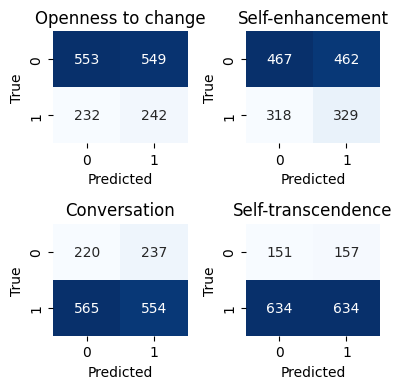

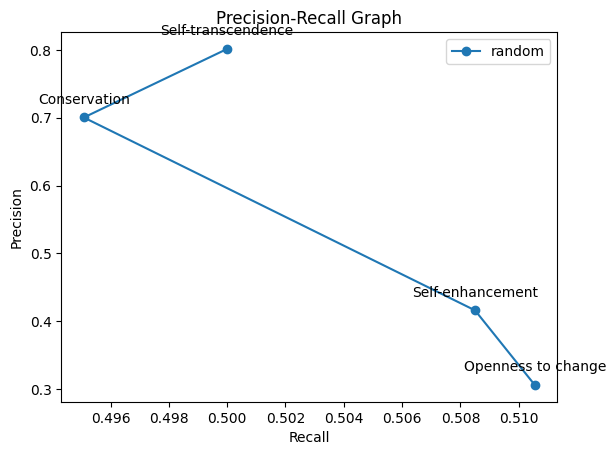

[0.3059418457648546, 0.415929203539823, 0.7003792667509482, 0.8015170670037927]
[0.510548523206751, 0.508500772797527, 0.49508489722966936, 0.5]


In [96]:
index = 0
print_cm(confusion_matrices_list[index])
print()
display_precision_recall(precision_list[index], recall_list[index], model_title[index],category_labels)
print(precision_list[index])
print(recall_list[index])

### Most Common

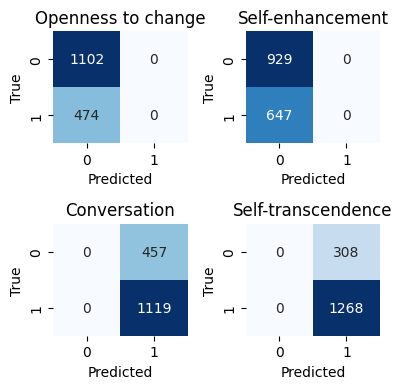

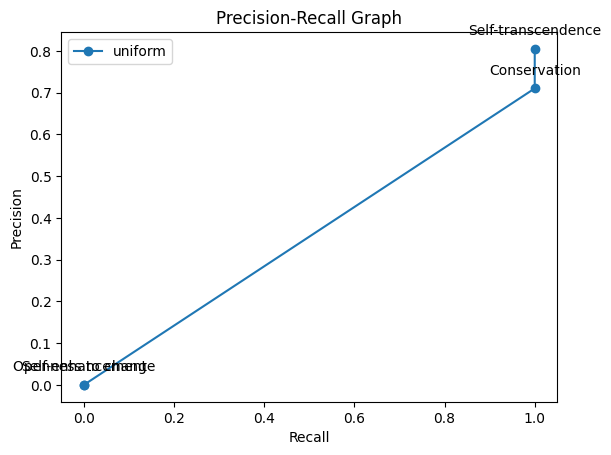

[0.0, 0.0, 0.7100253807106599, 0.8045685279187818]
[0.0, 0.0, 1.0, 1.0]


In [97]:
index = 1
print_cm(confusion_matrices_list[index])
print()
display_precision_recall(precision_list[index], recall_list[index], model_title[index],category_labels)
print(precision_list[index])
print(recall_list[index])

### Bert with Conclusion

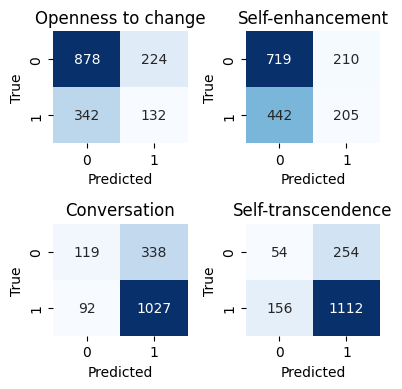

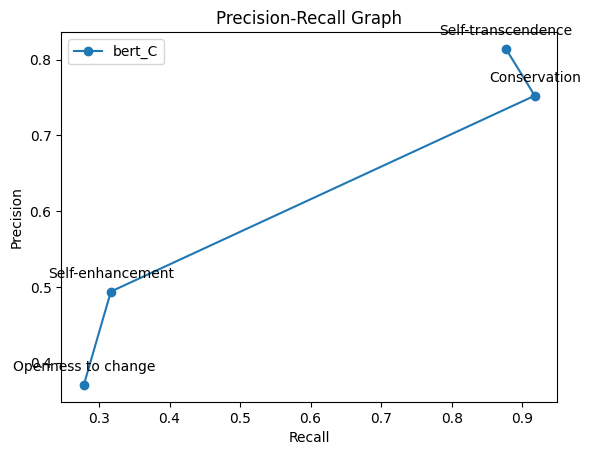

[0.3707865168539326, 0.4939759036144578, 0.7523809523809524, 0.8140556368960469]
[0.27848101265822783, 0.3168469860896445, 0.9177837354781054, 0.8769716088328076]


In [98]:
index = 2
print_cm(confusion_matrices_list[index])
print()
display_precision_recall(precision_list[index], recall_list[index], model_title[index],category_labels)
print(precision_list[index])
print(recall_list[index])

### Bert with Conclusion and Premise

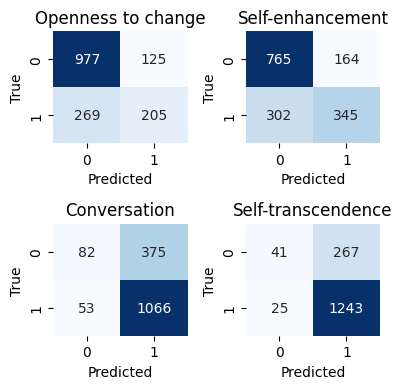

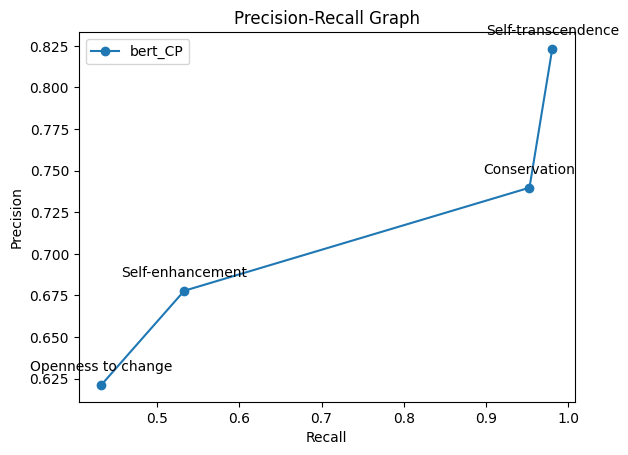

[0.6212121212121212, 0.6777996070726916, 0.739764052741152, 0.8231788079470199]
[0.43248945147679324, 0.5332302936630603, 0.9526362823949955, 0.9802839116719243]


In [99]:
index = 3
print_cm(confusion_matrices_list[index])
print()
display_precision_recall(precision_list[index], recall_list[index], model_title[index],category_labels)
print(precision_list[index])
print(recall_list[index])

### Bert with Conclusion, Premise and Stance

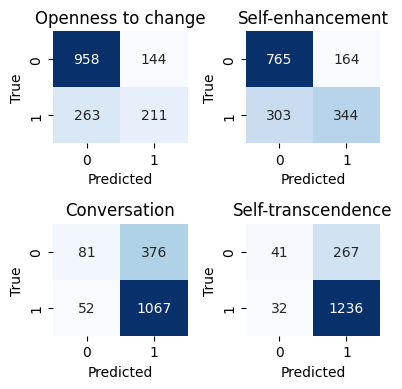

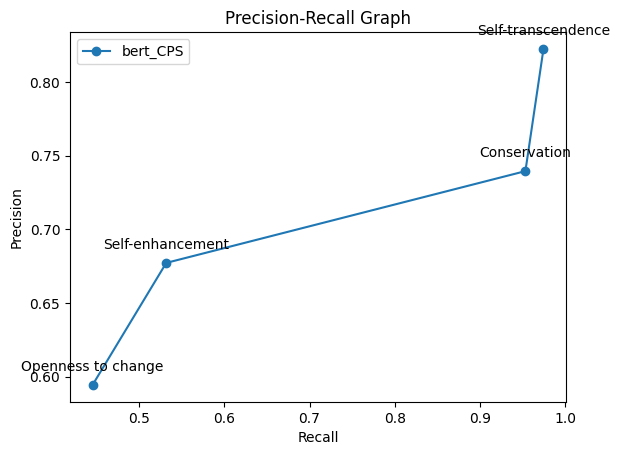

[0.5943661971830986, 0.6771653543307087, 0.7394317394317395, 0.8223552894211577]
[0.4451476793248945, 0.5316846986089645, 0.9535299374441466, 0.9747634069400631]


In [100]:
index = 4
print_cm(confusion_matrices_list[index])
print()
display_precision_recall(precision_list[index], recall_list[index], model_title[index],category_labels)
print(precision_list[index])
print(recall_list[index])

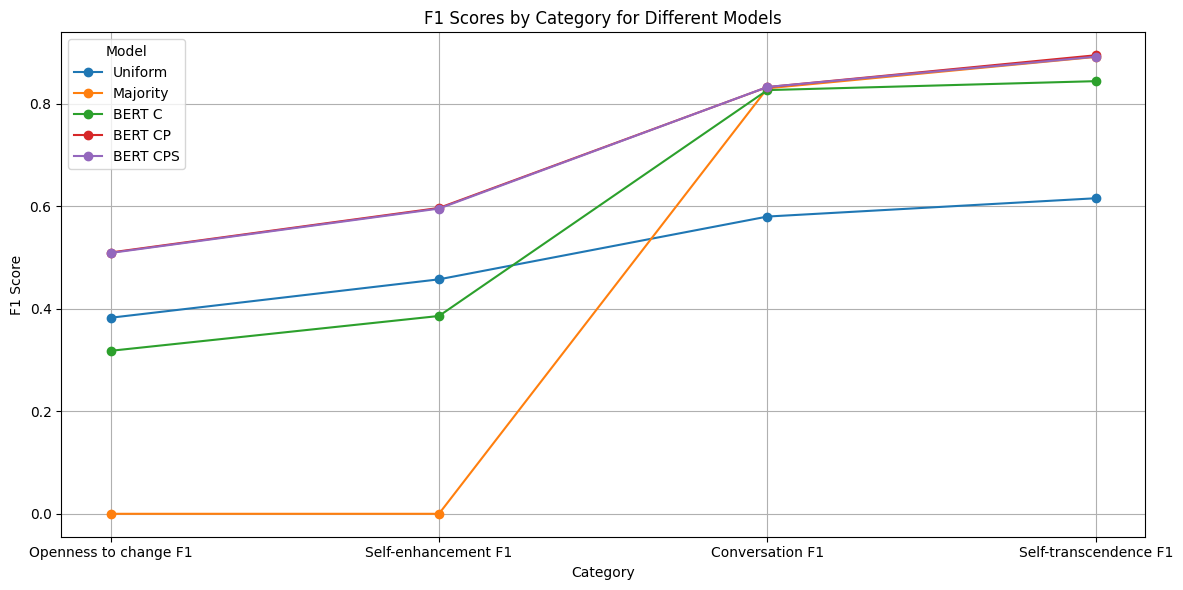

In [101]:
categories = ['Openness to change F1', 'Self-enhancement F1', 'Conversation F1', 'Self-transcendence F1']
models = ['Uniform', 'Majority', 'BERT C', 'BERT CP', 'BERT CPS']
f1_scores_by_model = {
    'Uniform': [metrics_uniform_test[cat] for cat in categories],
    'Majority': [metrics_most_common_test[cat] for cat in categories],
    'BERT C': [metrics_C[cat] for cat in categories],
    'BERT CP': [metrics_CP[cat] for cat in categories],
    'BERT CPS': [metrics_CPS[cat] for cat in categories]
}

# Create a line plot with categories on x-axis
plt.figure(figsize=(12, 6))

for model, f1_scores in f1_scores_by_model.items():
    plt.plot(categories, f1_scores, marker='o', label=model)

plt.title('F1 Scores by Category for Different Models')
plt.xlabel('Category')
plt.ylabel('F1 Score')
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()

plt.show()

In [102]:
predictions = test_prediction_info_CP.predictions
predictions = np.vectorize(round_elements)(predictions)
predictions = predictions.astype(float)
labels = test_prediction_info_CP.label_ids

In [103]:
def count_wrong_classifications(counter): # sampling the misclassifications
  wrong_classifications = []
  for idx in range(predictions.shape[0]):
    counter_missclassification = 0
    for i in range(predictions.shape[1]):
      if predictions[idx,i] != labels[idx,i]:
        counter_missclassification+=1
    if counter_missclassification >= counter:
      wrong_classifications.append(idx)
  return wrong_classifications

In [104]:
wrong_classifications = count_wrong_classifications(3)
test_data.iloc[wrong_classifications]

,Argument ID,Conclusion,Stance,Premise,Values
3,A26024,We should prohibit women in combat,1,women shouldn't be in combat because they aren...,"[0.0, 1.0, 0.0, 0.0]"
29,A27197,We should ban naturopathy,1,there is no scientific evidence that shows nat...,"[0.0, 1.0, 1.0, 1.0]"
74,A28072,We should prohibit women in combat,0,there is no reason to force those who are fit ...,"[1.0, 1.0, 0.0, 0.0]"
88,A28178,We should subsidize stay-at-home dads,0,staying at home is a choice since they know th...,"[1.0, 0.0, 0.0, 1.0]"
113,A28385,We should abandon marriage,1,there is no need for marriage in this society....,"[1.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...
1465,E04056,We should have legal migration channels.,0,Immigrants should try on their own to improve ...,"[0.0, 0.0, 0.0, 1.0]"
1490,E05041,We should develop civic education and media li...,0,Absolutely all such attempts merely lead to ne...,"[0.0, 0.0, 0.0, 1.0]"
1496,E05078,We should abolish unanimity voting,1,"Qualified voting is enough, if the need arises...","[0.0, 1.0, 0.0, 0.0]"
1517,E05149,We should forbid authorities to give tax advan...,0,How would you know how many cases where compan...,"[1.0, 0.0, 0.0, 1.0]"


In [105]:
wrong_classifications = count_wrong_classifications(4)
test_data.iloc[wrong_classifications]

,Argument ID,Conclusion,Stance,Premise,Values
74,A28072,We should prohibit women in combat,0,there is no reason to force those who are fit ...,"[1.0, 1.0, 0.0, 0.0]"
660,A31395,We should prohibit women in combat,0,if women want to stand up to fight and protect...,"[1.0, 1.0, 0.0, 0.0]"
